In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/case_study1/

/content/drive/MyDrive/case_study1


## Material backorder Prediction case study

Problem Statement

Material back-order is the slandered problem and related to the availability of the product when it is required for further production or the customer wants to purchase the same. Here machine learning will predict the probability of having backorders tendency and it will be very helpful since such tendency may result in the chance of losing customer since it will affect timely production or product shortage when a customer wants it

Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


Reading the train and test file

In [ ]:
train = pd.read_csv('data/kaggle/Kaggle_Training_Dataset_v2.csv')
test = pd.read_csv('data/kaggle/Kaggle_Test_Dataset_v2.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Data features are as follows:

sku - Random ID for the product

national_inv - Current inventory level for the part

lead_time - Transit time for product (if available)

in_transit_qty - Amount of product in transit from source

forecast_3_month - Forecast sales for the next 3 months

forecast_6_month - Forecast sales for the next 6 months

forecast_9_month - Forecast sales for the next 9 months

sales_1_month - Sales quantity for the prior 1 month time period

sales_3_month - Sales quantity for the prior 3 month time period

sales_6_month - Sales quantity for the prior 6 month time period

sales_9_month - Sales quantity for the prior 9 month time period

min_bank - Minimum recommend amount to stock

potential_issue - Source issue for part identified

pieces_past_due - Parts overdue from source

perf_6_month_avg - Source performance for prior 6 month period

perf_12_month_avg - Source performance for prior 12 month period

local_bo_qty - Amount of stock orders overdue

deck_risk - Part risk flag

oe_constraint - Part risk flag

ppap_risk - Part risk flag

stop_auto_buy - Part risk flag

rev_stop - Part risk flag

went_on_backorder - Product actually went on backorder. This is the target value.

Now we will first analyze the data. This step is important since after analysis we can decide which type of preprocessing is required on the data.

In [ ]:
test.tail(2)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
242074,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,88.0,4.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242075,(242075 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train.tail(2)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test=test.drop(test.iloc[-1:].index,inplace=False)   # remove last rows
train=train.drop(train.iloc[-1:].index,inplace=False)   # remove last rows

In [ ]:
df = train.append(test)    # merge both the file and create single dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1929935 entries, 0 to 242074
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   sku                object 
 1   national_inv       float64
 2   lead_time          float64
 3   in_transit_qty     float64
 4   forecast_3_month   float64
 5   forecast_6_month   float64
 6   forecast_9_month   float64
 7   sales_1_month      float64
 8   sales_3_month      float64
 9   sales_6_month      float64
 10  sales_9_month      float64
 11  min_bank           float64
 12  potential_issue    object 
 13  pieces_past_due    float64
 14  perf_6_month_avg   float64
 15  perf_12_month_avg  float64
 16  local_bo_qty       float64
 17  deck_risk          object 
 18  oe_constraint      object 
 19  ppap_risk          object 
 20  stop_auto_buy      object 
 21  rev_stop           object 
 22  went_on_backorder  object 
dtypes: float64(15), object(8)
memory usage: 353.4+ MB


Product went on backorder 13981 times 0.7244285429302023 %
Product Not went on backorder 1915954 times 99.2755714570698 %


([<matplotlib.patches.Wedge at 0x7f8d54e73890>,
 [Text(-1.0997151375435508, 0.02503230428005669, 'Product Not went on backorder'),
  Text(1.2996633440234235, -0.029583647541384123, 'Product went on backorder')],
 [Text(-0.5998446204783003, 0.013653984152758194, '99.3%'),
  Text(0.7997928270913375, -0.01820532156392869, '0.7%')])

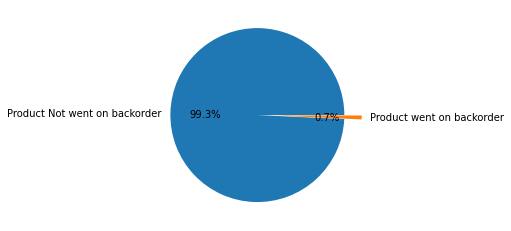

In [ ]:
p = df.went_on_backorder.value_counts()
print("Product went on backorder",p[1], "times",(p[1]*100/(p[1]+p[0])) , "%")
print("Product Not went on backorder",p[0], "times" , (p[0]*100/(p[1]+p[0])), "%")

fig, ax = plt.subplots()

labels = ['Product Not went on backorder', 
         'Product went on backorder']
explode = (0, 0.2) 
percentages = [p[0]*100/(p[1]+p[0]), p[1]*100/(p[1]+p[0])]

#Draw pie chart 
ax.pie(percentages, labels=labels, shadow=False,explode=explode,autopct='%1.1f%%')


From above data information we can see that out of 21 features and 1 label , 15 labels are having numeric values and rest are the non numeric features, so first we have to find the way to convert this non numeric features in to numeric. There are multiple ways to convert them to numeric values. Here we will apply perticular technique only after analyzing the feature.

Also data distribution is imbalance since only 0.7% labels are having output 1 (i.e.) Backorder initiated.

In [ ]:
df.head(5)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [ ]:

df.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [ ]:
df.tail(5)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
242070,3526987,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242071,3526988,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242072,3526989,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242073,3526990,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242074,3526991,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,88.0,4.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No


Remove Nan from dataset


In [ ]:
df.isna().sum()  # checking for Nan


sku                       0
national_inv              0
lead_time            115617
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

Here lead_time feature has highest number of NaN value so we cannot drop all these features , here replacing NaN for lead_time is discussed after EDA.

Univariate Analysis:

In [ ]:
df.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

For categorical data only Yes and No are there in labels.

In [ ]:
import matplotlib.pyplot as plt

def univariate_plot (data_df, x_l, Y_l ):


  p1 = data_df[x_l].loc[data_df[Y_l] == "No"].value_counts()
  p2 = data_df[x_l].loc[data_df[Y_l] == "Yes"].value_counts()

  #p1 = df["stop_auto_buy"].loc[df["went_on_backorder"] == "No"].value_counts()
  #p2 = df["stop_auto_buy"].loc[df["went_on_backorder"] == "Yes"].value_counts()


  df1 = pd.DataFrame({'Not_went_on_backorder': p1,
                    'went_on_backorder': p2})
  print(df1)
  fig.suptitle('stop_auto_buy = No')
  ax = df1.plot.bar(rot=100)

  print(x_l," state is No", "Product Not went on backorder",p1["No"], "times",  (p1["No"]*100/(p1[1]+p1[0]+p2[1]+p2[0])) , "%")
  print(x_l," state is No", "Product went on backorder",p2["No"], "times",  (p2["No"]*100/(p1[1]+p1[0]+p2[1]+p2[0])) , "%")

  
  print(x_l," state is Yes", "Product Not went on backorder",p1["Yes"], "times",  (p1["Yes"]*100/(p1[1]+p1[0]+p2[1]+p2[0])) , "%")
  print(x_l," state is Yes", "Product went on backorder",p2["Yes"], "times",  (p2["Yes"]*100/(p1[1]+p1[0]+p2[1]+p2[0])) , "%")


  #print("Product Not went on backorder",p1[1], "times", x_l," state is No", (p1[1]*100/(p1[1]+p1[0])) , "%")
 # print("Product Not went on backorder",p1[0], "times", x_l," state is Yes", (p1[0]*100/(p1[1]+p1[0])), "%")
  

 # print("Product went on backorder",p2[1], "times", x_l," state is No",(p2[1]*100/(p2[1]+p2[0])), "%")
 # print("Product went on backorder",p2[0], "times", x_l," state is Yes", (p2[0]*100/(p2[1]+p2[0])), "%")


### SKU

sku id the random ID generated for the product so we can ignore the same for prediction


### stop_auto_buy

     Not_went_on_backorder  went_on_backorder
Yes                1845988              13403
No                   69966                578
stop_auto_buy  state is No Product Not went on backorder 69966 times 3.6253034428620654 %
stop_auto_buy  state is No Product went on backorder 578 times 0.029949195180148554 %
stop_auto_buy  state is Yes Product Not went on backorder 1845988 times 95.65026801420773 %
stop_auto_buy  state is Yes Product went on backorder 13403 times 0.6944793477500537 %


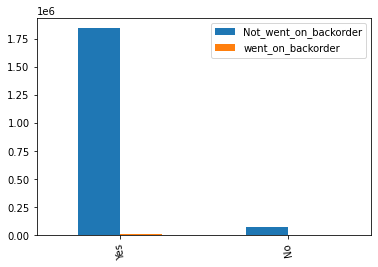

In [ ]:
univariate_plot (df, 'stop_auto_buy', 'went_on_backorder')

### oe_constraint

     Not_went_on_backorder  went_on_backorder
No                 1915670              13972
Yes                    283                  9
oe_constraint  state is No Product Not went on backorder 1915670 times 99.26090736781673 %
oe_constraint  state is No Product went on backorder 13972 times 0.7239625811038097 %
oe_constraint  state is Yes Product Not went on backorder 283 times 0.014663713888661478 %
oe_constraint  state is Yes Product went on backorder 9 times 0.0004663371908054887 %


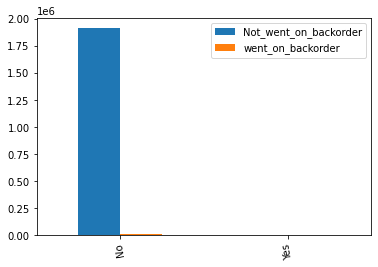

In [ ]:
univariate_plot (df, 'oe_constraint', 'went_on_backorder')

### deck_risk

     Not_went_on_backorder  went_on_backorder
No                 1482777              11704
Yes                 433176               2277
deck_risk  state is No Product Not went on backorder 1482777 times 76.83045119677668 %
deck_risk  state is No Product went on backorder 11704 times 0.6064456090208267 %
deck_risk  state is Yes Product Not went on backorder 433176 times 22.445119884928708 %
deck_risk  state is Yes Product went on backorder 2277 times 0.11798330927378864 %


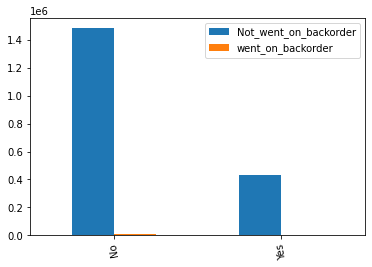

In [ ]:
univariate_plot (df, 'deck_risk', 'went_on_backorder')

### ppap_risk

     Not_went_on_backorder  went_on_backorder
No                 1685532              11850
Yes                 230421               2131
ppap_risk  state is No Product Not went on backorder 1685532 times 87.336250876973 %
ppap_risk  state is No Product went on backorder 11850 times 0.6140106345605602 %
ppap_risk  state is Yes Product Not went on backorder 230421 times 11.93932020473239 %
ppap_risk  state is Yes Product went on backorder 2131 times 0.11041828373405516 %


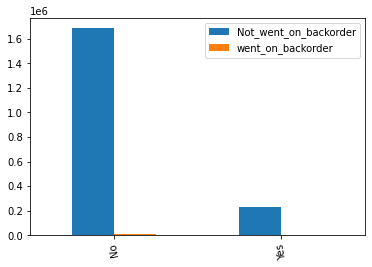

In [ ]:
univariate_plot (df, 'ppap_risk', 'went_on_backorder')

### rev_stop

     Not_went_on_backorder  went_on_backorder
No                 1915118              13977
Yes                    835                  4
rev_stop  state is No Product Not went on backorder 1915118 times 99.23230535344732 %
rev_stop  state is No Product went on backorder 13977 times 0.7242216573209239 %
rev_stop  state is Yes Product Not went on backorder 835 times 0.04326572825806478 %
rev_stop  state is Yes Product went on backorder 4 times 0.0002072609736913283 %


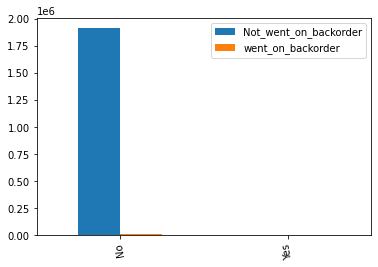

In [ ]:
univariate_plot (df, 'rev_stop', 'went_on_backorder')

Below Table shows how many times backordered generated with part risk flag 's status

Part Risk Flag | Status | % times When Backordered generated  |  % times When back ordered not generated
--- | --- | ---  | ---
stop_auto_buy | Yes  | 0.694 | 95.65 
stop_auto_buy | No  | 0.029 | 3.62 
oe_constraint | Yes  | 0.0004 | 0.014 
oe_constraint | No  | 0.72 | 99.26 
deck_risk | Yes  | 0.11 | 22.44 
deck_risk | No  | 0.60 | 76.83 
ppap_risk | Yes  | 11.93 | 0.11 
ppap_risk | No  | 0.61 | 87.33 
rev_stop | Yes  | 0.0002 | 0.043 
rev_stop | No  | 0.72 | 99.23

### potential_issue

     Not_went_on_backorder  went_on_backorder
No                 1915019              13927
Yes                    935                 54
potential_issue  state is No Product Not went on backorder 1915019 times 99.2271242295725 %
potential_issue  state is No Product went on backorder 13927 times 0.7216305212351711 %
potential_issue  state is Yes Product Not went on backorder 935 times 0.048447227497299135 %
potential_issue  state is Yes Product went on backorder 54 times 0.0027980216950311797 %


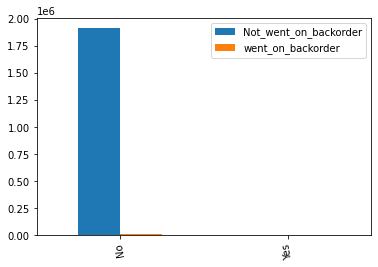

In [ ]:
univariate_plot (df, 'potential_issue', 'went_on_backorder')

Potential_issue is the source issue for part identified. There are very small no of events when the status of this feature is Yes.

Numeric Features

In [ ]:
df.head(2)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No


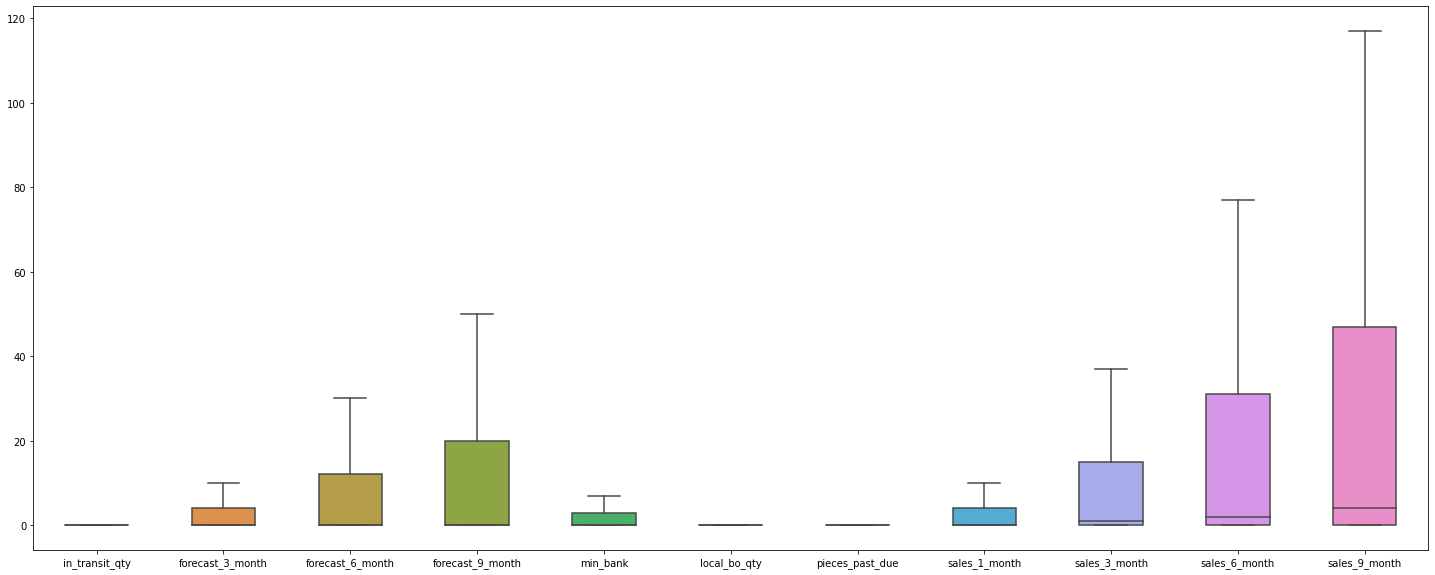

In [ ]:
num_data = [ 'in_transit_qty', 'forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   'sales_3_month', 'sales_6_month', 'sales_9_month',]
fig,ax = plt.subplots(figsize=(25,10),facecolor='white')
sns.boxplot(data=df[num_data],ax=ax,width=0.5,fliersize=4,showfliers=False)   # will not Show the outliers beyond the caps.

In [ ]:
## remove at end
Q1 = df['AVG'].quantile(0.25)
Q3 = df['AVG'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df['AVG'] >= Q1 - 1.5 * IQR) & (df['AVG'] <= Q3 + 1.5 *IQR)
df.loc[filter] 

In [ ]:
from sklearn.preprocessing import normalize    # normalize all numeric value
qty_related = ['national_inv', 'in_transit_qty', 'forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   'sales_3_month', 'sales_6_month', 'sales_9_month',]
df[qty_related] = normalize(df[qty_related], axis=1)

### national_inv

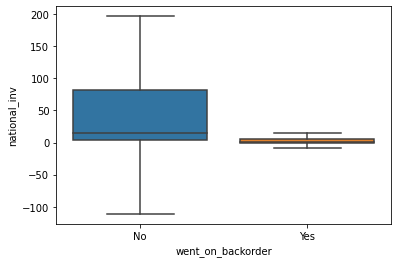

In [ ]:

sns.boxplot(  x=df["went_on_backorder"] ,y=df["national_inv"],showfliers=False)
plt.show()

For National_Inv feature shows current inventory level for the parts. Negative values are for the item ordered even they were available. From box plot it can be seen that national_inv is around zero for the events when back order generated.

In [ ]:
### to remove ourliers if required
Q1 = df['national_inv'].quantile(0.25)
Q3 = df['national_inv'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 

filter = (df['national_inv'] >= Q1 - 1.5 * IQR) & (df['national_inv'] <= Q3 + 1.5 *IQR)
df = df.loc[filter] 

### in_transit_qty

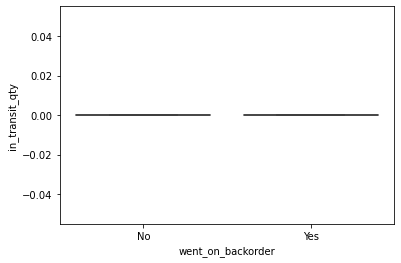

In [ ]:
sns.boxplot(  x=df["went_on_backorder"] ,y=df["in_transit_qty"],showfliers=False)
plt.show()



/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


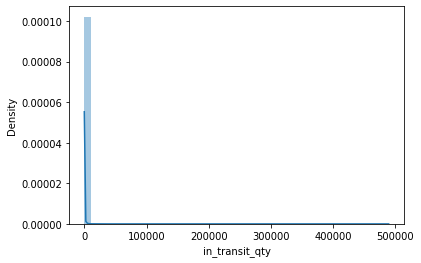

In [ ]:
sns.distplot(df.in_transit_qty,bins=50)

In [ ]:
for i in range(10):
  quantileValues = df.in_transit_qty.quantile((i*10)/100);

  print((i*10),"th percentile:");

  print(quantileValues);

0 th percentile:
0.0
10 th percentile:
0.0
20 th percentile:
0.0
30 th percentile:
0.0
40 th percentile:
0.0
50 th percentile:
0.0
60 th percentile:
0.0
70 th percentile:
0.0
80 th percentile:
1.0
90 th percentile:
15.0


In [ ]:
for i in range(11):
  quantileValues = df.in_transit_qty.quantile((i+90)/100);

  print((i+90),"th percentile:");

  print(quantileValues);

90 th percentile:
15.0
91 th percentile:
20.0
92 th percentile:
26.0
93 th percentile:
35.0
94 th percentile:
48.0
95 th percentile:
66.0
96 th percentile:
96.0
97 th percentile:
145.0
98 th percentile:
250.0
99 th percentile:
565.0
100 th percentile:
489408.0


In [ ]:
for i in range(11):
  quantileValues = df.in_transit_qty.quantile((i+990)/1000);

  print((i+990)/10,"th percentile:");

  print(quantileValues);

99.0 th percentile:
565.0
99.1 th percentile:
630.0
99.2 th percentile:
720.0
99.3 th percentile:
830.0
99.4 th percentile:
990.0
99.5 th percentile:
1193.0
99.6 th percentile:
1500.0
99.7 th percentile:
2040.0
99.8 th percentile:
2998.2639999999665
99.9 th percentile:
5503.462000000756
100.0 th percentile:
489408.0


70% items in this feature is having 0 value. 99 % features are having value less then 565.

### forecast_3_month, forecast_6_month , forecast_9_month

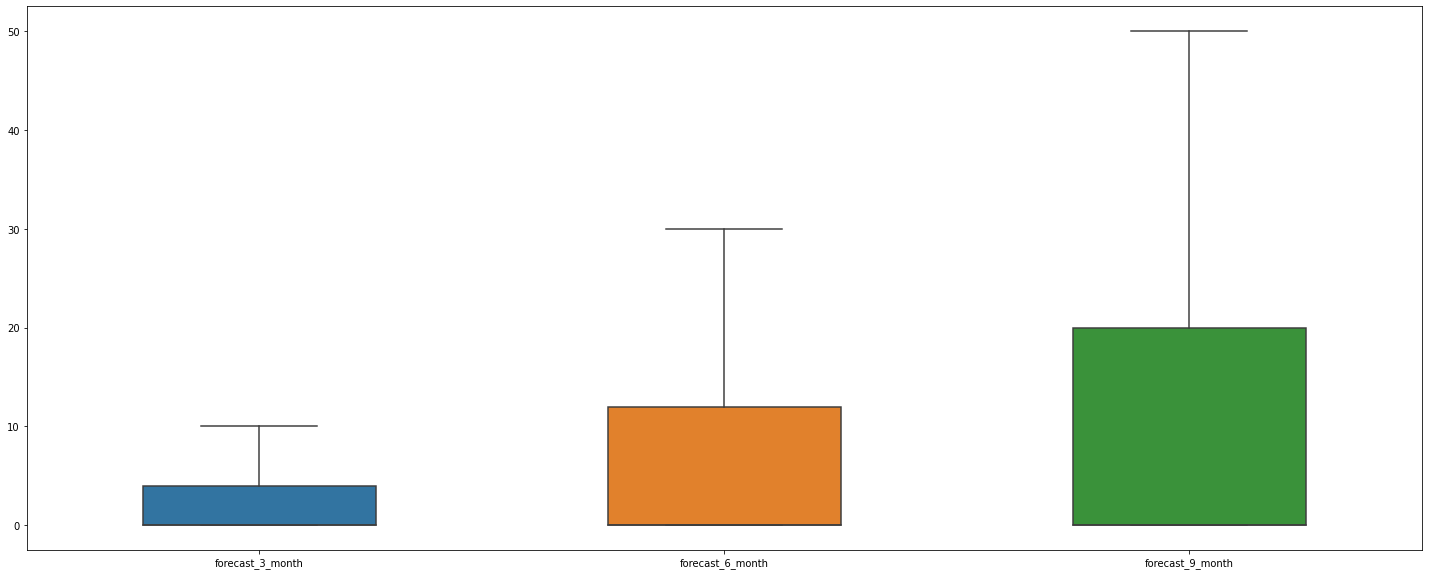

In [ ]:
num_data = [ 'forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month',]
fig,ax = plt.subplots(figsize=(25,10),facecolor='white')
sns.boxplot(data=df[num_data],ax=ax,width=0.5,fliersize=4,showfliers=False)   # will not Show the outliers beyond the caps.

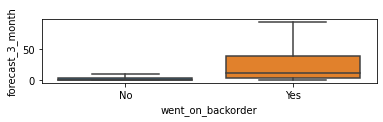

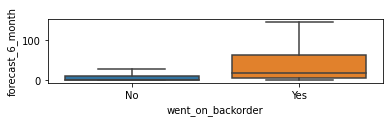

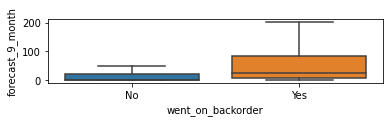

In [ ]:
plt.subplot(3,1,1)
sns.boxplot(  x=df["went_on_backorder"] ,y=df["forecast_3_month"],showfliers=False)
plt.show()
plt.subplot(3,1,2)

sns.boxplot(  x=df["went_on_backorder"] ,y=df["forecast_6_month"],showfliers=False)
plt.show()
plt.subplot(3,1,3)

sns.boxplot(  x=df["went_on_backorder"] ,y=df["forecast_9_month"],showfliers=False)
plt.show()

Forecast sell for next 3,6 and 9 months are higher in case of product went on backorder compare to product not went on backorder.

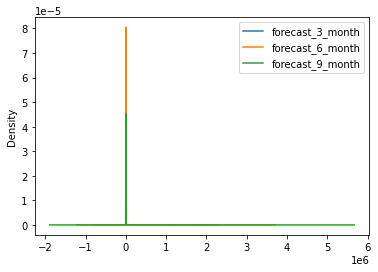

In [ ]:
qty_related = ['forecast_3_month', 'forecast_6_month', 'forecast_9_month',]
df[qty_related].plot.kde()

Distribution of all three features are overlap. From the plot it looks like all variables are highlly correlated.

In [ ]:
corr = df[qty_related].corr()
corr.style.background_gradient(cmap='coolwarm')

,forecast_3_month,forecast_6_month,forecast_9_month
forecast_3_month,1.000000,0.988112,0.971443
forecast_6_month,0.988112,1.000000,0.994281
forecast_9_month,0.971443,0.994281,1.000000


Here from the correlation map it can be seen that forecast_6_month and forecast_9_month are highly correlated and we can skip one of them.

### min_bank

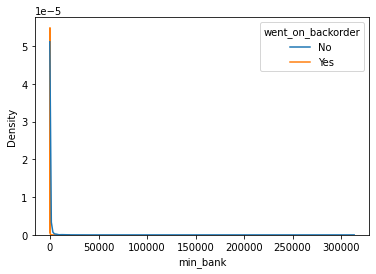

In [ ]:
sns.kdeplot(data=df, x="min_bank", hue="went_on_backorder")

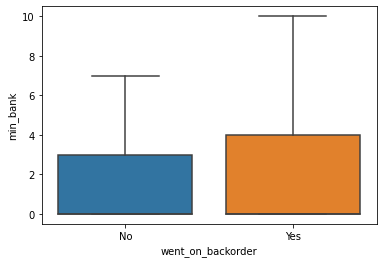

In [ ]:
sns.boxplot(  x=df["went_on_backorder"] ,y=df["min_bank"],showfliers=False );
plt.show()


For min_bank feature data is highly overlap for both the labels

### local_bo_qty

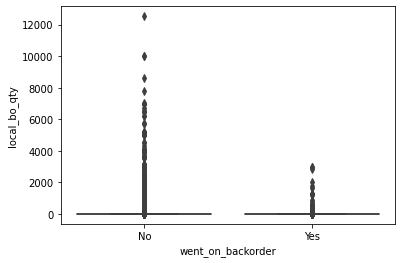

In [ ]:
sns.boxplot(  x=df["went_on_backorder"] ,y=df["local_bo_qty"],);
plt.show()


In [ ]:
for i in range(11):
  quantileValues = df.local_bo_qty.quantile((i+90)/100);

  print((i+90),"th percentile:");

  print(quantileValues);

90 th percentile:
0.0
91 th percentile:
0.0
92 th percentile:
0.0
93 th percentile:
0.0
94 th percentile:
0.0
95 th percentile:
0.0
96 th percentile:
0.0
97 th percentile:
0.0
98 th percentile:
0.0
99 th percentile:
1.0
100 th percentile:
12530.0


In [ ]:
for i in range(11):
  quantileValues = df.local_bo_qty.quantile((i+990)/1000);

  print((i+990)/10,"th percentile:");

  print(quantileValues);

99.0 th percentile:
1.0
99.1 th percentile:
2.0
99.2 th percentile:
2.0
99.3 th percentile:
3.0
99.4 th percentile:
4.0
99.5 th percentile:
7.0
99.6 th percentile:
10.0
99.7 th percentile:
18.0
99.8 th percentile:
35.0
99.9 th percentile:
99.0
100.0 th percentile:
12530.0


For local_bo_qty is amount of stock order overdue, 98 % of samples are having zero value.This feature may be ignored since most of values of the feature is zero.

### pieces_past_due

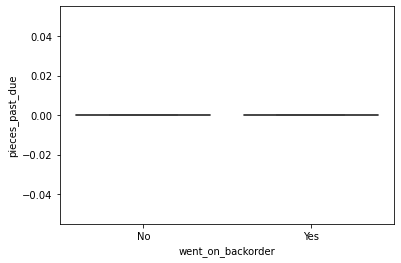

90 th percentile:
0.0
91 th percentile:
0.0
92 th percentile:
0.0
93 th percentile:
0.0
94 th percentile:
0.0
95 th percentile:
0.0
96 th percentile:
0.0
97 th percentile:
0.0
98 th percentile:
0.0
99 th percentile:
4.0
100 th percentile:
146496.0


In [ ]:
sns.boxplot(  x=df["went_on_backorder"] ,y=df["pieces_past_due"],showfliers=False);
plt.show()
for i in range(11):
  quantileValues = df.pieces_past_due.quantile((i+90)/100);

  print((i+90),"th percentile:");

  print(quantileValues);

In [ ]:
for i in range(11):
  quantileValues = df.pieces_past_due.quantile((i+990)/1000);

  print((i+990)/10,"th percentile:");

  print(quantileValues);

99.0 th percentile:
4.0
99.1 th percentile:
6.0
99.2 th percentile:
9.0
99.3 th percentile:
12.0
99.4 th percentile:
17.0
99.5 th percentile:
24.0
99.6 th percentile:
36.0
99.7 th percentile:
56.0
99.8 th percentile:
100.0
99.9 th percentile:
240.0
100.0 th percentile:
146496.0


For pieces_past_due is part overdue from source, 98 % of samples are having zero value.This feature may be ignored since most of values of the feature is zero.

### 'sales_1_month', 'sales_3_month', 'sales_6_month','sales_9_month'

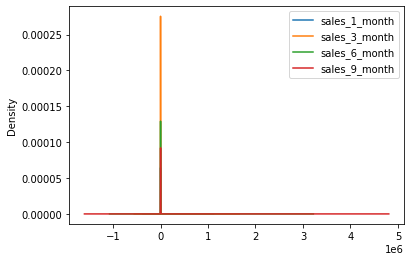

In [ ]:
qty_related = ['sales_1_month', 'sales_3_month', 'sales_6_month','sales_9_month',]
df[qty_related].plot.kde()

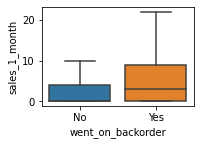

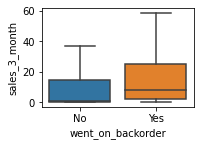

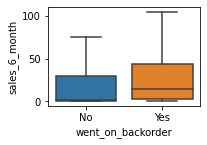

In [ ]:
plt.subplot(2,2,1)
sns.boxplot(  x=df["went_on_backorder"] ,y=df["sales_1_month"],showfliers=False)
plt.show()
plt.subplot(2,2,2)

sns.boxplot(  x=df["went_on_backorder"] ,y=df["sales_3_month"],showfliers=False)
plt.show()
plt.subplot(2,2,3)

sns.boxplot(  x=df["went_on_backorder"] ,y=df["sales_6_month"],showfliers=False)
plt.show()

In [ ]:
corr = df[qty_related].corr()
corr.style.background_gradient(cmap='coolwarm')

,sales_1_month,sales_3_month,sales_6_month,sales_9_month
sales_1_month,1.000000,0.918282,0.873111,0.824634
sales_3_month,0.918282,1.000000,0.975437,0.930531
sales_6_month,0.873111,0.975437,1.000000,0.973871
sales_9_month,0.824634,0.930531,0.973871,1.000000


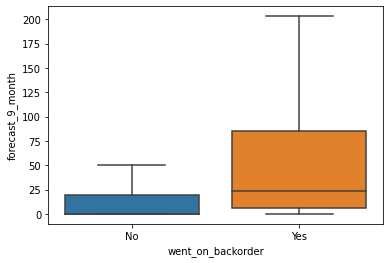

In [ ]:
sns.boxplot(  x=df["went_on_backorder"] ,y=df["forecast_9_month"],showfliers=False);
plt.show()



From the above graphs it can be observe that for sales 1 month, 3 month and 9 month , sell is higher in case of product went on backorder.

### perf_6_month_avg	,perf_12_month_avg

In [ ]:
df.perf_6_month_avg.value_counts()

 0.99     163323
 1.00     150339
-99.00    148579
 0.73     128818
 0.98      97390
           ...  
 0.20        921
 0.03        829
 0.04        724
 0.01        648
 0.29        572
Name: perf_6_month_avg, Length: 102, dtype: int64

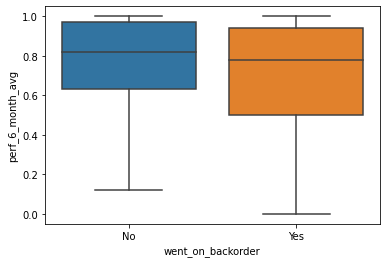

In [ ]:
sns.boxplot(  x=df["went_on_backorder"] ,y=df["perf_6_month_avg"],showfliers=False);
plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


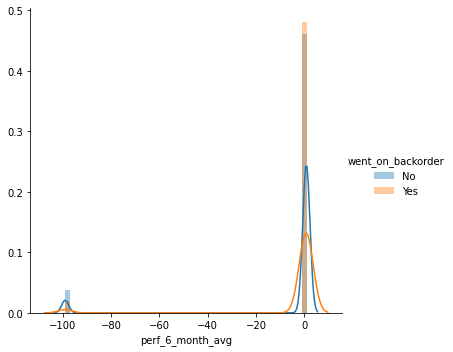

In [ ]:
sns.FacetGrid(df,hue="went_on_backorder", size = 5).map(sns.distplot,"perf_6_month_avg").add_legend()

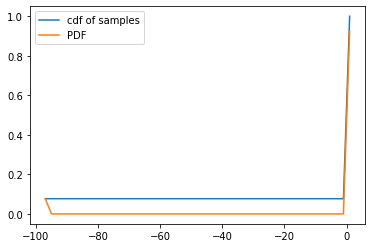

In [ ]:
#https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/
import numpy as np

# Sample from a normal distribution using numpy's random number generator
samples = df.perf_6_month_avg

# Compute a histogram of the sample

histogram, bins = np.histogram(samples, bins=50, density=True)



# Compute the PDF on the bin centers from scipy distribution object
from scipy import stats
pdf = histogram/(sum(histogram))
cdf = np.cumsum(pdf)
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(bins[1:], cdf, label="cdf of samples")
plt.plot(bins[1:], pdf, label="PDF")
plt.legend()
plt.show()

Only 10 % samples are having value below 0. 

###Bivariate : 

Scatter_plot

In [ ]:
df.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


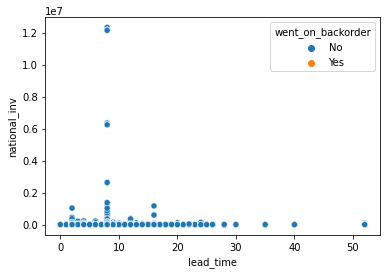

In [ ]:
sns.scatterplot(df.lead_time,df.national_inv,hue=df.went_on_backorder)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


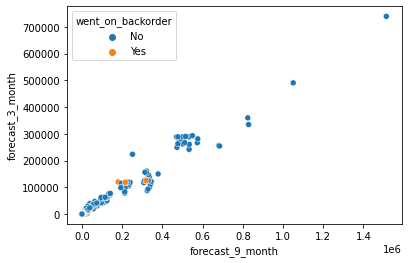

In [ ]:
sns.scatterplot(df.forecast_9_month,df.forecast_3_month,hue=df.went_on_backorder)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


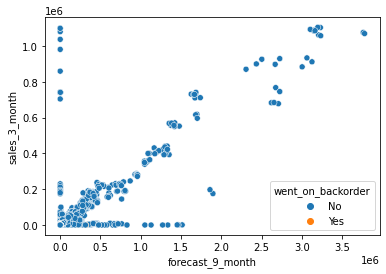

In [ ]:
sns.scatterplot(df.forecast_9_month,df.sales_3_month,hue=df.went_on_backorder)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


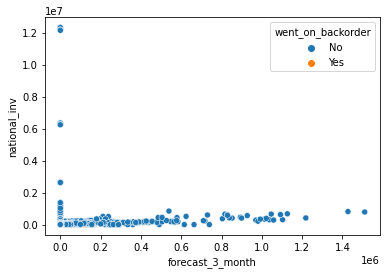

In [ ]:
sns.scatterplot(df.forecast_3_month,df.national_inv,hue=df.went_on_backorder)


From all scatter plot it can be seen that data are overlap and very hard to classify using above plots.

<Figure size 432x288 with 0 Axes>

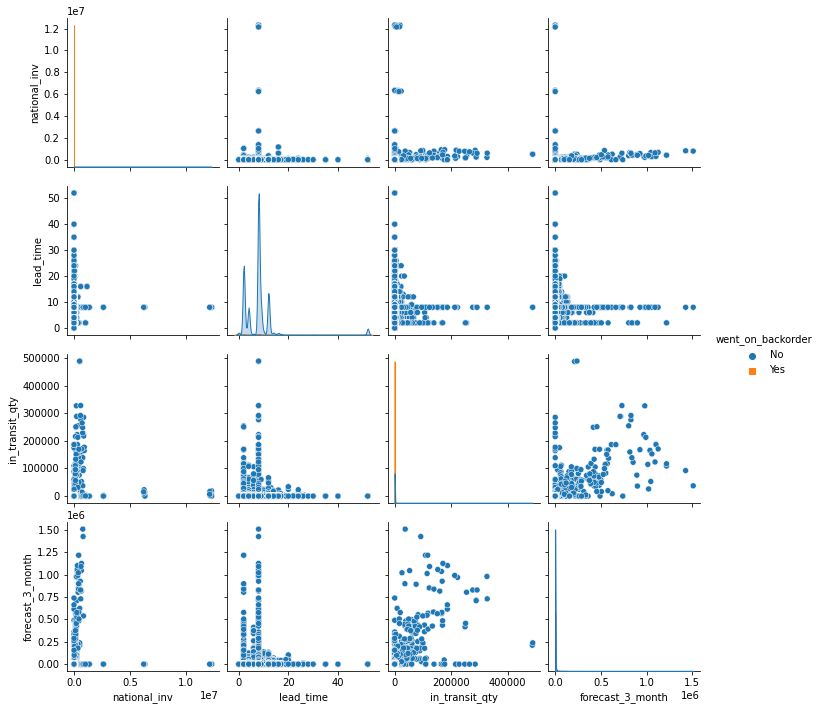

In [ ]:
#https://stackoverflow.com/questions/64556501/plot-only-some-columns-with-seaborn-pairplot

plt.figure()
cols_to_plot = df.columns[1:5].tolist() + ['went_on_backorder'] # explicitly add the column "Outcome" to your list of columns to plot
sns.pairplot(df[cols_to_plot], hue ="went_on_backorder", markers=["o", "s"])
plt.show()

In [ ]:
#https://stackoverflow.com/questions/64556501/plot-only-some-columns-with-seaborn-pairplot

plt.figure()
cols_to_plot = df.columns[5:9].tolist() + ['went_on_backorder'] # explicitly add the column "Outcome" to your list of columns to plot
sns.pairplot(df[cols_to_plot], hue ="went_on_backorder", markers=["o", "s"])
plt.show()

# Preprocessing 

1. Numeric features are at different scales and for some of the data range is very large so it is required to normalize such features.
2. For categorical features, all are having two
possible values which are Yes and No, which can be converted into binary numbers 0 and 1.
3. SKU is a unique number that is not important for classification and hence it can be dropped.
4. Some features are having negative values and those are meaningful in terms of information so those should keep as it is.
5. In lead_time no of Nan is 115617. using model-based imputation NaN values are replaced.
6. Very few samples are having NaN and hence we can drop them.
7. Data is highly imbalanced and hence it should be balanced by sampling or any other method after splitting them into train and test



In [ ]:
df1.to_csv('df_missing_through_model.csv', index=False)

#model testing

In [ ]:
!pip install missingpy

     |████████████████████████████████| 51kB 4.5MB/s 


<Figure size 1440x1440 with 0 Axes>

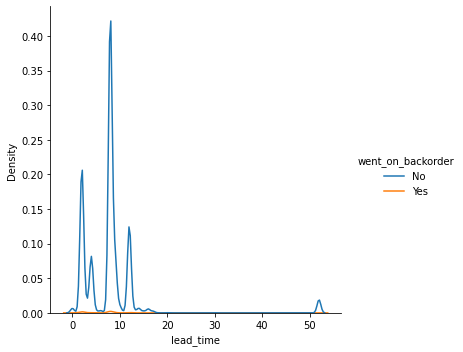

In [ ]:
plt.figure(figsize=(20,20))
sns.displot(data=df, x="lead_time", hue="went_on_backorder", kind="kde")


FOr all categorical data having two value: yes and No. so we will convert them in to binary values 1 and 0. For all other numerical features we will normalize them. For few features which are having nagitive value, we will use different approach to check the overall performance. 

In [ ]:

# Imput missing lines and drop line with problem
from sklearn.impute import SimpleImputer
  

# Convert to binaries
for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk',
               'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
        df[col] = (df[col] == 'Yes').astype(int)
# Normalization    
from sklearn.preprocessing import normalize
qty_related = ['national_inv', 'in_transit_qty', 'forecast_3_month', 
                   'forecast_6_month', 'forecast_9_month', 'min_bank',
                   'local_bo_qty', 'pieces_past_due', 'sales_1_month', 
                   'sales_3_month', 'sales_6_month', 'sales_9_month',]
df[qty_related] = normalize(df[qty_related], axis=1)


Here missingpy library is used for missing data imputation. It has two types of model support for mission data imputation. Random forest based data imputation and KNN based data imputation.

In [ ]:
"""MissForest imputes missing values using Random Forests in an iterative fashion [1]. 
By default, the imputer begins imputing missing values of the column (which is expected to be a variable) 
with the smallest number of missing values -- let's call this the candidate column. 
The first step involves filling any missing values of the remaining, non-candidate, 
columns with an initial guess, which is the column mean for columns representing numerical variables 
and the column mode for columns representing categorical variables. Note that the categorical variables need to be 
explicitly identified during the imputer's fit() method call (see API for more information). After that, the imputer 
fits a random forest model with the candidate column as the outcome variable and the remaining columns as the predictors 
over all rows where the candidate column values are not missing. After the fit, the missing rows of the candidate column 
are imputed using the prediction from the fitted Random Forest. The rows of the non-candidate columns act as the input data 
for the fitted model. Following this, the imputer moves on to the next candidate column with the second smallest number of 
missing values from among the non-candidate columns in the first round. The process repeats itself for each column with a 
missing value, possibly over multiple iterations or epochs for each column, until the stopping criterion is met. 
The stopping criterion is governed by the "difference" between the imputed arrays over successive iterations."""
from missingpy import MissForest
imputer = MissForest()
df = imputer.fit_transform(df)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [ ]:
df1 = pd.DataFrame(df)

In [ ]:
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1026827.0,0.000000,7.57,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,-99.00,-99.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1043384.0,1.000000,9.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.99,0.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1043696.0,1.000000,46.90,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1043852.0,0.989949,8.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.141421,0.0,0.0,0.10,0.13,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1044048.0,0.872872,17.98,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.436436,0.218218,0.0,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929930,3526987.0,0.996546,12.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.083045,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1929931,3526988.0,0.997054,12.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.076696,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1929932,3526989.0,0.997054,12.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.076696,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1929933,3526990.0,0.995037,12.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.099504,0.0,0.0,0.48,0.48,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df1.to_csv('df_missing_through_model.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [ ]:
df2 = pd.read_csv('df_missing_through_model.csv')
df2.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1026827.0,0.000000,7.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-99.00,-99.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1043384.0,1.000000,9.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.99,0.99,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1043696.0,1.000000,46.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1043852.0,0.989949,8.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.141421,0.0,0.0,0.10,0.13,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1044048.0,0.872872,17.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436436,0.218218,0.0,0.0,-99.00,-99.00,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df2.columns = ['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


In [ ]:
df2.head(1)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827.0,0.0,7.57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-99.0,-99.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
X = df2.drop(['went_on_backorder','sku'],axis=1)
y = df2['went_on_backorder']

# Model 1 : random over sample with RandomForestClassifier

In [ ]:
#https://github.com/krishnaik06/Handle-Imbalanced-Dataset/blob/master/handling-imbalanced.ipynb

from imblearn.over_sampling import RandomOverSampler


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y, train_size=0.7)

# transform the dataset

os=RandomOverSampler(0.75)



X_train, y_train = os.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# RandomForestClassifier classifier used
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rfc=rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[571093   3694]
 [  3172   1022]]
0.9881412343410233
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    574787
         1.0       0.22      0.24      0.23      4194

    accuracy                           0.99    578981
   macro avg       0.61      0.62      0.61    578981
weighted avg       0.99      0.99      0.99    578981



In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer

roc =  roc_auc_score(y_test, y_pred)
print("AUC Score is :", roc)

AUC Score is : 0.618627360590084


#Smote for over sample with RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)

# transform the dataset

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)


rf = RandomForestClassifier()
rfc=rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

roc =  roc_auc_score(y_test, y_pred)
print("AUC Score is :", roc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1628560
1628560
[[283998   3396]
 [   917   1180]]
0.9851014366595162
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    287394
         1.0       0.26      0.56      0.35      2097

    accuracy                           0.99    289491
   macro avg       0.63      0.78      0.67    289491
weighted avg       0.99      0.99      0.99    289491

AUC Score is : 0.7754460503808268


##Averaging of multiple models with SMOTE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE




X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)

# transform the dataset

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3= LogisticRegression()

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

pred1=model1.predict_proba(X_test)
pred2=model2.predict_proba(X_test)
pred3=model3.predict_proba(X_test)

finalpred=(pred1+pred2+pred3)/3


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:

print(confusion_matrix(y_test,np.argmax(finalpred,axis=1)))
print(accuracy_score(y_test,np.argmax(finalpred,axis=1)))
print(classification_report(y_test,np.argmax(finalpred,axis=1)))
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer

roc =  roc_auc_score(y_test, np.argmax(finalpred,axis=1))
print("AUC Score is :", roc)

[[279524   7870]
 [   645   1452]]
0.9705863049283052
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    287394
         1.0       0.16      0.69      0.25      2097

    accuracy                           0.97    289491
   macro avg       0.58      0.83      0.62    289491
weighted avg       0.99      0.97      0.98    289491

AUC Score is : 0.8325168651096768


In [ ]:
roc =  roc_auc_score(y_test, np.argmax(pred1,axis=1))
print("AUC Score is :", roc)

AUC Score is : 0.7377662277832001


In [ ]:
roc =  roc_auc_score(y_test, np.argmax(pred2,axis=1))
print("AUC Score is :", roc)

AUC Score is : 0.8217624590042294


In [ ]:
roc =  roc_auc_score(y_test, np.argmax(pred3,axis=1))
print("AUC Score is :", roc)

AUC Score is : 0.8298632450695039


#Undersample the data

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)

In [ ]:
from collections import Counter
from imblearn.under_sampling import NearMiss
ns=NearMiss()
X_train_ns,y_train_ns=ns.fit_sample(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


11884
11884


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_split=15,)
rfc=rf.fit(X_train_ns, y_train_ns)
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 85289 202105]
 [    92   2005]]
0.30154305315191143
              precision    recall  f1-score   support

         0.0       1.00      0.30      0.46    287394
         1.0       0.01      0.96      0.02      2097

    accuracy                           0.30    289491
   macro avg       0.50      0.63      0.24    289491
weighted avg       0.99      0.30      0.45    289491



In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer

roc =  roc_auc_score(y_test, y_pred)
print("AUC Score is :", roc)

AUC Score is : 0.6264473047787537


#adaboost classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)

# transform the dataset


oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
clf = AdaBoostClassifier(algorithm = "SAMME.R", learning_rate = 0.1)
clf.fit(X_train,y_train) 
y_pred = clf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer

roc =  roc_auc_score(y_test, y_pred)
print("AUC Score is :", roc)

[[243170  44224]
 [   339   1758]]
0.8460642990628379
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92    287394
         1.0       0.04      0.84      0.07      2097

    accuracy                           0.85    289491
   macro avg       0.52      0.84      0.49    289491
weighted avg       0.99      0.85      0.91    289491

AUC Score is : 0.8422305715343273


#XGBClassifier with SMOTE

In [ ]:
X = df2.drop(['went_on_backorder','sku'],axis=1)
y = df2['went_on_backorder']

In [ ]:
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer
from imblearn.over_sampling import SMOTE


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)



oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)


#https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer



lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    roc =  roc_auc_score(y_test, gb_clf.predict(X_test))

    print("Gradient Bosssting algorithm at lr",learning_rate, "AUC Score is ",roc )




/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Gradient Bosssting algorithm at lr 0.05 AUC Score is  0.829915077329052
Gradient Bosssting algorithm at lr 0.075 AUC Score is  0.834305562163702
Gradient Bosssting algorithm at lr 0.1 AUC Score is  0.8398305574688069
Gradient Bosssting algorithm at lr 0.25 AUC Score is  0.8520098317669961
Gradient Bosssting algorithm at lr 0.5 AUC Score is  0.8544669969654695
Gradient Bosssting algorithm at lr 0.75 AUC Score is  0.8507290958344305
Gradient Bosssting algorithm at lr 1 AUC Score is  0.8518704733014806


In [ ]:
df2.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import normalize
df3 = df2
qty_related = ['lead_time','perf_6_month_avg','perf_12_month_avg']
df3[qty_related] = normalize(df3[qty_related], axis=1)

In [ ]:
X = df3.drop(['went_on_backorder','sku','pieces_past_due'],axis=1)
y = df3['went_on_backorder']

#RandomForestClassifier with SMOTE (normalize all numeric values)

In [ ]:
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)


#https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer



from sklearn import tree, ensemble
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
lst = [10,15,20]
for i in lst:
  forest = ensemble.RandomForestClassifier(criterion='entropy', max_depth=i, min_samples_leaf=15)

  forest.fit(X_train, y_train)

  roc =  roc_auc_score(y_test, forest.predict(X_test))

  print("Gradient Bosssting algorithm at septh of",i, "AUC Score is ",roc )




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Gradient Bosssting algorithm at septh of 10 AUC Score is  0.8717498062083284
Gradient Bosssting algorithm at septh of 15 AUC Score is  0.8712651839150937
Gradient Bosssting algorithm at septh of 20 AUC Score is  0.8630476215735415


In [ ]:
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)


#https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer



from sklearn import tree, ensemble
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
lst = [10,15,20]
for i in lst:
  forest = ensemble.RandomForestClassifier(criterion='entropy', max_depth=i, min_samples_leaf=5)

  forest.fit(X_train, y_train)

  roc =  roc_auc_score(y_test, forest.predict(X_test))

  print("Gradient Bosssting algorithm at septh of",i, "AUC Score is ",roc )




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Gradient Bosssting algorithm at septh of 10 AUC Score is  0.8717239709692355
Gradient Bosssting algorithm at septh of 15 AUC Score is  0.8686389099030435
Gradient Bosssting algorithm at septh of 20 AUC Score is  0.8552027238446005


In [ ]:
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)


#https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer



from sklearn import tree, ensemble
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
lst = [5,10,15]
for i in lst:
  forest = ensemble.RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=i)

  forest.fit(X_train, y_train)

  roc =  roc_auc_score(y_test, forest.predict(X_test))

  print("Gradient Boosting algorithm at min_samples_leaf of",i, "AUC Score is ",roc )




/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Gradient Bosssting algorithm at min_samples_leaf of 5 AUC Score is  0.8689953117553235
Gradient Bosssting algorithm at min_samples_leaf of 10 AUC Score is  0.8704310591224463
Gradient Bosssting algorithm at min_samples_leaf of 15 AUC Score is  0.872174833225567


#stacking classifiercv

In [ ]:
df3 = df2

#df3.comforecast_6_month = df3.forecast_6_month + df3.forecast_9_month

In [ ]:
from sklearn.preprocessing import normalize
qty_related = ['lead_time','perf_6_month_avg','perf_12_month_avg']
df3[qty_related] = normalize(df3[qty_related], axis=1)

In [ ]:
X = df3.drop(['went_on_backorder','sku','pieces_past_due'],axis=1)
y = df3['went_on_backorder']

In [ ]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import numpy as np
import warnings

X_train1, X_test, y_train1, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)


oversample = SMOTE()
for i in range(5,10,1):
  X_train, y_train = RandomUnderSampler(random_state=i).fit_sample(X_train1,y_train1) 

  #X_train, y_train = oversample.fit_resample(X_train, y_train)


  warnings.simplefilter('ignore')

  clf1 = KNeighborsClassifier(n_neighbors=1)
  clf2 = RandomForestClassifier(random_state=1)
  clf3 = GaussianNB()
  lr = LogisticRegression()
  sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr)

  for clf, label in zip([clf1, clf2, clf3, sclf], 
                        ['KNN', 
                        'Random Forest', 
                        'Naive Bayes',
                        'StackingClassifier']):

      clf.fit(X_train, y_train)

      print("Classifier",label)
      print(confusion_matrix(y_test,clf.predict(X_test)))
      print(accuracy_score(y_test,clf.predict(X_test)))
      print(classification_report(y_test,clf.predict(X_test)))
      from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer

      roc =  roc_auc_score(y_test, clf.predict(X_test))
      print("AUC Score is :", roc)

Classifier KNN
[[245310  42084]
 [   235   1862]]
0.853815835380029
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92    287394
         1.0       0.04      0.89      0.08      2097

    accuracy                           0.85    289491
   macro avg       0.52      0.87      0.50    289491
weighted avg       0.99      0.85      0.91    289491

AUC Score is : 0.8707510128782643
Classifier Random Forest
[[251673  35721]
 [   197   1900]]
0.8759270581814288
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93    287394
         1.0       0.05      0.91      0.10      2097

    accuracy                           0.88    289491
   macro avg       0.52      0.89      0.51    289491
weighted avg       0.99      0.88      0.93    289491

AUC Score is : 0.8908817440664046
Classifier Naive Bayes
[[213410  73984]
 [   326   1771]]
0.7433080821165425
              precision    recall  f1-score   support


#MLP based classification

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC


X_train1, X_test, y_train1, y_test = train_test_split(X, y, stratify=y,test_size=0.15, random_state=70)


oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train1, y_train1)
model = Sequential()
model.add(Dense(128, input_dim=20))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
# this is the output for one-hot vector
model.add(Activation('sigmoid'))
model.summary()




model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# train the network
model.fit(X_train, y_train, epochs=10, batch_size=128)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               2688      
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
ff = model.predict(X_test)

In [ ]:
roc =  roc_auc_score(y_test,ff)
print("AUC Score is :", roc)
      

AUC Score is : 0.9405758870258877


## Summary

Model | Test AUC Score 
--- | --- 
RandomForestClassifier with Random over sample` | 0.618627360590084 
RandomForestClassifier with SMOTE | 0.7754460503808268 
Averaging of multiple models with SMOTE | 0.8325168651096768
RandomForestClassifier with undersample the data | 0.6264473047787537
SMOTE with BOOSTING(AdaBoostClassifier) | 0.8422305715343273 
XGBClassifier with SMOTE | 0.8520098317669961
RandomForestClassifier with SMOTE (normalize all numeric values) | 0.872174833225567
stacking classifiercv(KNN,NB,Randomforest) with randomunder sample | 0.8914159411469469
MLP based classification | 0.9405758870258877

